# ECS7026P - Neural Networks and Deep Learning Coursework: CIFAR-10 Classification

#### **Student ID Number:** 230290873
#### **Name:** Aman Naredi

# Installing required libraried

In [13]:
! pip install torch
! seaborn

/bin/bash: line 1: seaborn: command not found


In [14]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [16]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


In [11]:
# Number of classes
class_names = trainset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# 1. Loading train and test datastets by creating Dataloaders
The function below, `'load_data_CIFR'` prepares the `CIFAR-10 dataset` for the required classification task. It applies `transformations` to enhance `training data`, like `random flips` and `crops` and `normalizes` both `training` and `testing` data. The train and test datasets are downloaded into the memory using torchvision. Then, it creates DataLoader objects for efficient data loading during training and evaluation.

The function takes 2 arguments, 'BATCH_SIZE' and resize (set to None as all images are of same size 3x32x32). 

In [17]:
# Create DataLoaders
def load_data_CIFR(BATCH_SIZE, resize=None):
    """Download the CIFR dataset and then load it into memory."""
    train_transformations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    )
    test_transformations = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )


    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformations)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformations)

    return (torch.utils.data.DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True), # Using pinned memory
            torch.utils.data.DataLoader(testset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)) #


# Architecture
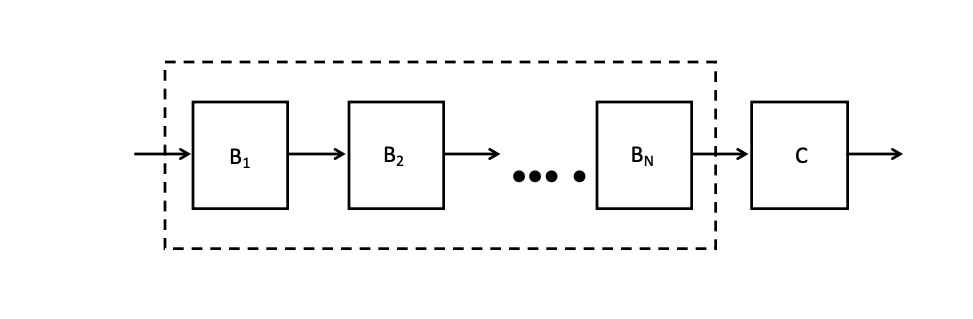
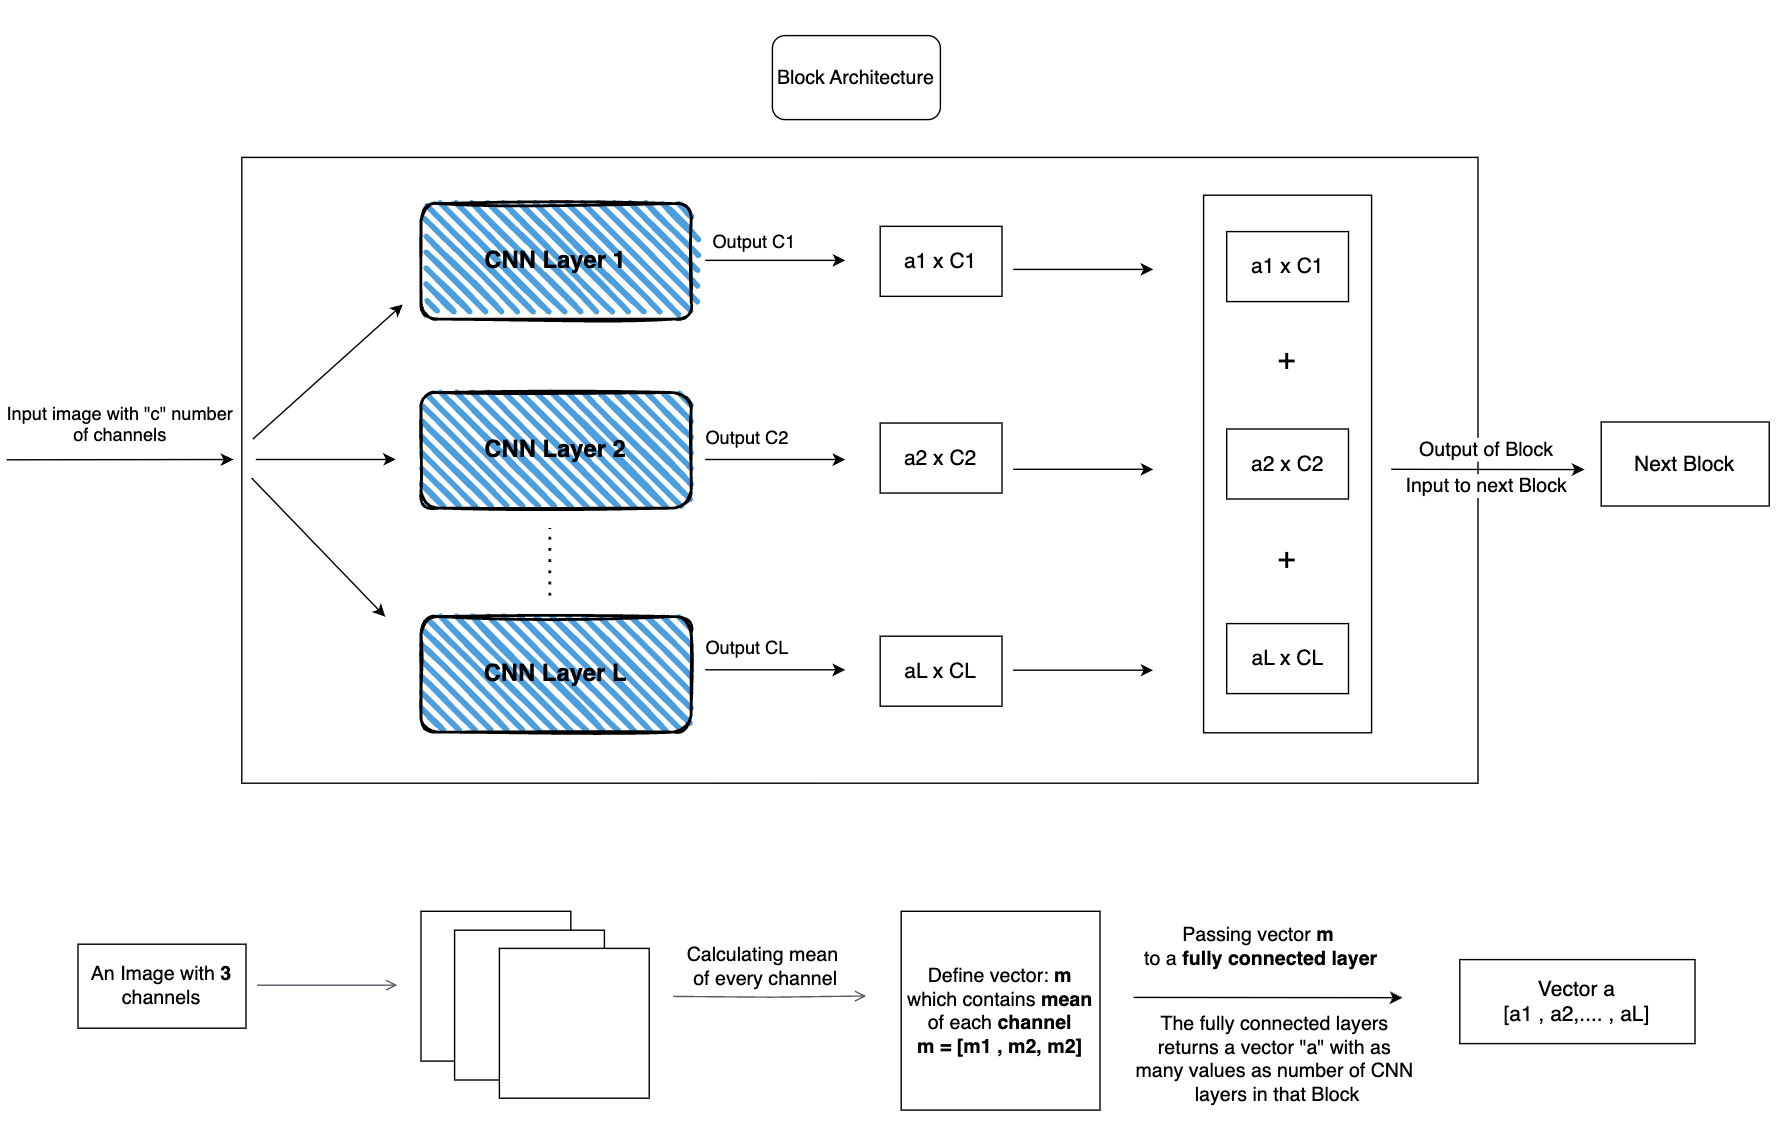

OutPut Block Architecture
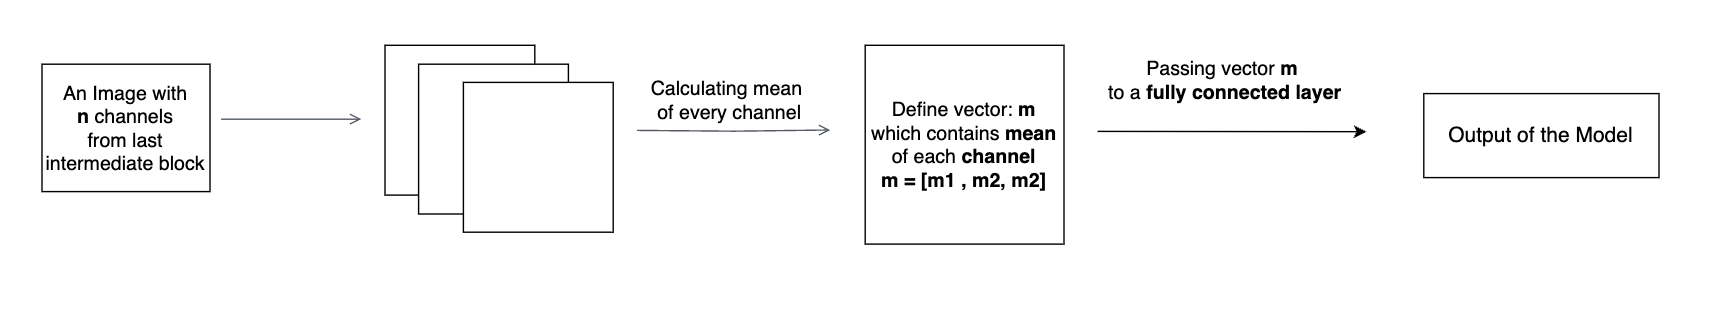

# 2. Basic Architecture


In [18]:
# Loading datasets

BATCH_SIZE = 64
train_iter, test_iter = load_data_CIFR(BATCH_SIZE, resize=(32, 32))



Files already downloaded and verified
Files already downloaded and verified


## 2.1 Intermediate Block
The 'IntermediateBlock' class defines the block architecture of my neural network model. 
* It takes two inputs, the input channel count and the number of convolutional layers. Then, it creates a list to store the convolutional layers. Each layer comprises a (in_channels x in_channels) convolution, batch normalization, and ReLU activation. It utilizes ModuleList to manage these layers. 
* Secondly a fully connected layer is set up for the calculation of 'a' vector.
* In the forward method, it computes the mean of the input tensor, passes it through the fully connected layer followed by a softmax to get a vector 'a'. It iterates through convolutional layers passing input to each convolutional layer, multiplying each output by the corresponding 'a' value and sums them up to produce the final output if the Block.


In [19]:
# Define the Intermediate Block
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels=3, num_convs=5):
        super(IntermediateBlock, self).__init__()
        
        self.num_convs = num_convs # defining number of convulation layers for the block
        self.convs = [] # creating an instance of convs list to store all sequential convolutional layers defined below

        # iteratively appending number of convolutional layers
        for i in range(self.num_convs):
            self.convs.append(nn.Sequential(
                                    torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
                                    torch.nn.BatchNorm2d(in_channels),
                                    torch.nn.ReLU()))

        self.convs = torch.nn.ModuleList(self.convs) # Ensures that each module in the list is considered a submodule of this block

        self.fc = torch.nn.Linear(in_channels, num_convs) # 

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        a = torch.softmax(self.fc(m), dim=1)  # Calculate 'a' using a fully connected layer
       
        outPut = []
        # multiplyting output of i'th convolutional layer with i'th index value of vector "a" and appending the values in list "Output"
        for i, conv in enumerate(self.convs):
          outPut.append(a[:, i].view(-1, 1, 1, 1) * conv(x))
            
        x_prime = sum(outPut) # summing up all the values in outPut list 
        
        return x_prime # return the sum value as the output of Block

        


## 2.2 Output Block
The OutputBlock class defines the last block of my neural network model. It takes 3 arguments in the initialization step, the input channel count, the number of fully connected layers inside the output block (default value set to 1) and the number of output features(that is number of classes which is 10).
* 'self.fcs' stores the (number of fully connected Linear layers - 1)  intermediate Linear layers sequentially.
*  Intermediate Linear Layers takes an input of size equal to input channel count and outputs the vector of the same size as input. All layers are connected sequentially.
* The last Linear layer gets input from last intermediate Linear layer and outputs the vector of size equal to the number of output features that is 10 (number of classes).
* Forward Method:
  * It computes the mean of the input tensor across the width and height dimensions.
  * It passes the mean through each fully connected layer (if any), applying a softmax function after each layer.
  * Finally, it passes the output through the last linear layer to get logits, which are returned as the output of the block.

In [20]:

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_fcs=1, out_features=10):
        super(OutputBlock, self).__init__()
        
        self.fcs = nn.ModuleList()
        if num_fcs > 0:
            for _ in range(num_fcs - 1):
                self.fcs.append(nn.Linear(in_channels, in_channels))
        self.fc_last = nn.Linear(in_channels, out_features)

    def forward(self, x):
        # Calculate channel-wise averages
        m = x.mean([2, 3])
        # Pass through fully-connected layers
        out = m
        for fc in self.fcs:
            out = F.softmax(fc(out))
        # Get logits
        logits = self.fc_last(out)
        return logits

## 2.3 BasicNet Model
The BasicNet class defines the model. It takes five parameters, the number of input channels, the number of intermediate blocks, the number of convolution layers in each block, the number of fully connected layers in the output block and the number of classes.
* It creates a series of blocks using the IntermediateBlock class and also adds the Output Block using the OutputBlock class.

* Forward Method:
    * It iterates through each block in the blocks ModuleList, applying them sequentially to the input tensor x(image).
Then, it passes the resulting tensor through the out_block to get the final output, which is returned as the output of my neural network model.


In [21]:
class BasicNet(nn.Module):
    def __init__(self, in_channels, num_blocks, num_convs_per_block, num_fcs_out, num_classes):
        super(BasicNet, self).__init__()
        self.blocks = nn.ModuleList([IntermediateBlock(in_channels, num_convs = num_convs_per_block) for _ in range(num_blocks)])
        self.out_block = OutputBlock(in_channels, num_fcs_out, num_classes)

    def forward(self, x):
        for i,block in enumerate(self.blocks):
            x = block(x)
        x = self.out_block(x)
        return x

# 3. Training and Testing of Basic Net Model

## 3.1 Defining hyperparameters, Model, Optimizer and Loss function
* `IN_CHANNELS` --> Number of Input channels = 3, as an image as 3 channels.
* `NUM_CONVS_PER_BLOCK` = 7, which is the number of convolution layers in each intermediate block.
* `NUM_BLOCKS` --> Number of Intermediate Blocks = 7.
* `NUM_FCS_OUT` --> Number of fully connected layers in output layer = 3.
* `NUM_CLASSES` --> 10
  
**Loss Function** --> **`CrossEntropy`**
I have used the Cross-Entropy loss function as mentioned. It is commonly used for multiple class classification tasks.

**Optimizer** --> **`ADAM`**
I have used Adam, as it is an adaptive learning rate optimization algorithm that is well-suited for training deep neural networks. It maintains adaptive learning rates for each parameter and computes individual learning rates for different parameters based on estimates of the first and second moments of the gradients. In this case, it's used to optimize the parameters of the model with a learning rate (lr) of 0.001.



In [24]:
# Define network hyperparameters
IN_CHANNELS = 3  # Number of channels in CIFAR-10 images
NUM_BLOCKS = 7  # Number of intermediate blocks
NUM_CONVS_PER_BLOCK = 5  # Number of convolutions per block
NUM_FCS_OUT = 1 # Number linear layers in output block
NUM_CLASSES = 10  # Number of classes in CIFAR-10

# Instantiate the model
model = BasicNet(IN_CHANNELS, NUM_BLOCKS, NUM_CONVS_PER_BLOCK, NUM_FCS_OUT, NUM_CLASSES).to(DEVICE)

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [25]:
# Printing the layers of BasicNet model
print(model)

BasicNet(
  (blocks): ModuleList(
    (0-6): 7 x IntermediateBlock(
      (convs): ModuleList(
        (0-4): 5 x Sequential(
          (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (fc): Linear(in_features=3, out_features=5, bias=True)
    )
  )
  (out_block): OutputBlock(
    (fcs): ModuleList()
    (fc_last): Linear(in_features=3, out_features=10, bias=True)
  )
)


## 3.2 Defining the Training and Testing functions
Training and Testing are implemented via two functions:

- **Training Function (`train`)**:
  - It sets the model to training mode and initializes variables to track total loss and correct predictions.
  - It iterates over the training data, moving the data and labels to the appropriate device (CPU or GPU).
  - For each batch, it performs a forward pass through the model, computes the loss, performs backpropagation, and updates the model's parameters.
  - It calculates the accuracy by comparing the model's predictions to the true labels and accumulates the loss.
  - Finally, it computes the train loss and accuracy over the entire training dataset and returns these values.

- **Testing Function (`test`)**:
  - It sets the model to evaluation mode, disabling operations like dropout for consistency.
  - It iterates over the test data, moving it to the device and computing the model's output.
  - It calculates the loss and accuracy similarly to the training function but without backpropagation.
  - Finally, it computes and returns the test loss and accuracy over the entire test dataset.


In [26]:
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0

    for data, target in train_loader:
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        data, target = data.to(DEVICE), target.to(DEVICE)  # Move data to device

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100 * correct / len(train_loader.dataset)

    return average_loss, accuracy


def test(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode (no dropout etc.)
    total_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            total_loss += loss.item()

    average_loss = total_loss / len(test_loader.dataset)
    accuracy = 100 * correct / len(test_loader.dataset)

    return average_loss, accuracy

## 3.3 Training the Basic Neural Network Model
`NUM_EPOCHS` --> Number of Epochs set to 35
* I have checked running for the 25 and 50 number of epochs also. The accuracy seemed to be increasing after 25th epoch so I went for more epochs 50, but models accuracy was not increasing after 35th epoch so I fixed it to 35.



In [70]:
from tqdm import tqdm
NUM_EPOCHS = 35
train_loss_per_epoch = [] #to store train loss of each epoch
train_accuracy_per_epoch = [] #to store train accuracy of each epoch
test_loss_per_epoch = [] #to store test loss of each epoch
test_accuracy_per_epoch = [] #to store test accuracy of each epoch
# Training loop
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    train_loss, train_accuracy = train(model, train_iter, criterion, optimizer)
    test_loss, test_accuracy = test(model, test_iter, criterion)
    
    train_loss_per_epoch.append(train_loss)
    train_accuracy_per_epoch.append(train_accuracy)
    test_loss_per_epoch.append(test_loss)
    test_accuracy_per_epoch.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print("--------------------------------------------")


Epochs:   3%|▎         | 1/35 [00:47<27:01, 47.69s/it]

Epoch [1/35], Train Loss: 0.0333, Train Accuracy: 18.39%
Epoch [1/35], Test Loss: 0.0315, Test Accuracy: 22.10%
--------------------------------------------


Epochs:   6%|▌         | 2/35 [01:35<26:11, 47.63s/it]

Epoch [2/35], Train Loss: 0.0302, Train Accuracy: 25.45%
Epoch [2/35], Test Loss: 0.0300, Test Accuracy: 25.79%
--------------------------------------------


Epochs:   9%|▊         | 3/35 [02:22<25:11, 47.23s/it]

Epoch [3/35], Train Loss: 0.0287, Train Accuracy: 29.37%
Epoch [3/35], Test Loss: 0.0280, Test Accuracy: 30.61%
--------------------------------------------


Epochs:  11%|█▏        | 4/35 [03:09<24:32, 47.51s/it]

Epoch [4/35], Train Loss: 0.0275, Train Accuracy: 31.19%
Epoch [4/35], Test Loss: 0.0273, Test Accuracy: 31.44%
--------------------------------------------


Epochs:  14%|█▍        | 5/35 [03:57<23:43, 47.45s/it]

Epoch [5/35], Train Loss: 0.0269, Train Accuracy: 32.14%
Epoch [5/35], Test Loss: 0.0265, Test Accuracy: 32.54%
--------------------------------------------


Epochs:  17%|█▋        | 6/35 [04:45<23:04, 47.73s/it]

Epoch [6/35], Train Loss: 0.0264, Train Accuracy: 33.23%
Epoch [6/35], Test Loss: 0.0266, Test Accuracy: 33.88%
--------------------------------------------


Epochs:  20%|██        | 7/35 [05:32<22:09, 47.50s/it]

Epoch [7/35], Train Loss: 0.0260, Train Accuracy: 34.58%
Epoch [7/35], Test Loss: 0.0258, Test Accuracy: 36.29%
--------------------------------------------


Epochs:  23%|██▎       | 8/35 [06:18<21:11, 47.10s/it]

Epoch [8/35], Train Loss: 0.0256, Train Accuracy: 36.35%
Epoch [8/35], Test Loss: 0.0272, Test Accuracy: 34.53%
--------------------------------------------


Epochs:  26%|██▌       | 9/35 [07:06<20:32, 47.40s/it]

Epoch [9/35], Train Loss: 0.0251, Train Accuracy: 37.25%
Epoch [9/35], Test Loss: 0.0255, Test Accuracy: 36.23%
--------------------------------------------


Epochs:  29%|██▊       | 10/35 [07:54<19:44, 47.36s/it]

Epoch [10/35], Train Loss: 0.0246, Train Accuracy: 38.56%
Epoch [10/35], Test Loss: 0.0240, Test Accuracy: 39.55%
--------------------------------------------


Epochs:  31%|███▏      | 11/35 [08:41<18:56, 47.35s/it]

Epoch [11/35], Train Loss: 0.0243, Train Accuracy: 39.28%
Epoch [11/35], Test Loss: 0.0238, Test Accuracy: 40.16%
--------------------------------------------


Epochs:  34%|███▍      | 12/35 [09:27<17:59, 46.93s/it]

Epoch [12/35], Train Loss: 0.0240, Train Accuracy: 39.84%
Epoch [12/35], Test Loss: 0.0246, Test Accuracy: 38.46%
--------------------------------------------


Epochs:  37%|███▋      | 13/35 [10:14<17:13, 46.99s/it]

Epoch [13/35], Train Loss: 0.0237, Train Accuracy: 40.16%
Epoch [13/35], Test Loss: 0.0287, Test Accuracy: 35.90%
--------------------------------------------


Epochs:  40%|████      | 14/35 [11:01<16:24, 46.89s/it]

Epoch [14/35], Train Loss: 0.0235, Train Accuracy: 40.64%
Epoch [14/35], Test Loss: 0.0257, Test Accuracy: 34.16%
--------------------------------------------


Epochs:  43%|████▎     | 15/35 [11:44<15:17, 45.86s/it]

Epoch [15/35], Train Loss: 0.0234, Train Accuracy: 41.05%
Epoch [15/35], Test Loss: 0.0244, Test Accuracy: 40.69%
--------------------------------------------


Epochs:  46%|████▌     | 16/35 [12:23<13:48, 43.62s/it]

Epoch [16/35], Train Loss: 0.0232, Train Accuracy: 41.42%
Epoch [16/35], Test Loss: 0.0240, Test Accuracy: 40.97%
--------------------------------------------


Epochs:  49%|████▊     | 17/35 [13:01<12:37, 42.10s/it]

Epoch [17/35], Train Loss: 0.0232, Train Accuracy: 41.63%
Epoch [17/35], Test Loss: 0.0256, Test Accuracy: 39.28%
--------------------------------------------


Epochs:  51%|█████▏    | 18/35 [13:41<11:42, 41.32s/it]

Epoch [18/35], Train Loss: 0.0231, Train Accuracy: 42.01%
Epoch [18/35], Test Loss: 0.0251, Test Accuracy: 37.06%
--------------------------------------------


Epochs:  54%|█████▍    | 19/35 [14:20<10:49, 40.61s/it]

Epoch [19/35], Train Loss: 0.0229, Train Accuracy: 42.11%
Epoch [19/35], Test Loss: 0.0226, Test Accuracy: 42.76%
--------------------------------------------


Epochs:  57%|█████▋    | 20/35 [14:57<09:54, 39.65s/it]

Epoch [20/35], Train Loss: 0.0228, Train Accuracy: 42.49%
Epoch [20/35], Test Loss: 0.0231, Test Accuracy: 41.97%
--------------------------------------------


Epochs:  60%|██████    | 21/35 [15:35<09:06, 39.04s/it]

Epoch [21/35], Train Loss: 0.0228, Train Accuracy: 42.52%
Epoch [21/35], Test Loss: 0.0285, Test Accuracy: 37.91%
--------------------------------------------


Epochs:  63%|██████▎   | 22/35 [16:14<08:26, 38.98s/it]

Epoch [22/35], Train Loss: 0.0227, Train Accuracy: 42.89%
Epoch [22/35], Test Loss: 0.0247, Test Accuracy: 39.75%
--------------------------------------------


Epochs:  66%|██████▌   | 23/35 [16:51<07:43, 38.65s/it]

Epoch [23/35], Train Loss: 0.0226, Train Accuracy: 43.44%
Epoch [23/35], Test Loss: 0.0230, Test Accuracy: 42.14%
--------------------------------------------


Epochs:  69%|██████▊   | 24/35 [17:28<06:57, 38.00s/it]

Epoch [24/35], Train Loss: 0.0226, Train Accuracy: 43.40%
Epoch [24/35], Test Loss: 0.0239, Test Accuracy: 41.45%
--------------------------------------------


Epochs:  71%|███████▏  | 25/35 [18:02<06:07, 36.79s/it]

Epoch [25/35], Train Loss: 0.0225, Train Accuracy: 43.56%
Epoch [25/35], Test Loss: 0.0231, Test Accuracy: 41.29%
--------------------------------------------


Epochs:  74%|███████▍  | 26/35 [18:40<05:35, 37.32s/it]

Epoch [26/35], Train Loss: 0.0224, Train Accuracy: 43.89%
Epoch [26/35], Test Loss: 0.0239, Test Accuracy: 42.11%
--------------------------------------------


Epochs:  77%|███████▋  | 27/35 [19:19<05:01, 37.71s/it]

Epoch [27/35], Train Loss: 0.0224, Train Accuracy: 43.87%
Epoch [27/35], Test Loss: 0.0236, Test Accuracy: 42.55%
--------------------------------------------


Epochs:  80%|████████  | 28/35 [19:58<04:25, 37.94s/it]

Epoch [28/35], Train Loss: 0.0223, Train Accuracy: 44.20%
Epoch [28/35], Test Loss: 0.0236, Test Accuracy: 40.48%
--------------------------------------------


Epochs:  83%|████████▎ | 29/35 [20:36<03:49, 38.21s/it]

Epoch [29/35], Train Loss: 0.0222, Train Accuracy: 44.64%
Epoch [29/35], Test Loss: 0.0242, Test Accuracy: 43.06%
--------------------------------------------


Epochs:  86%|████████▌ | 30/35 [21:15<03:11, 38.34s/it]

Epoch [30/35], Train Loss: 0.0222, Train Accuracy: 44.75%
Epoch [30/35], Test Loss: 0.0232, Test Accuracy: 43.15%
--------------------------------------------


Epochs:  89%|████████▊ | 31/35 [21:53<02:32, 38.24s/it]

Epoch [31/35], Train Loss: 0.0221, Train Accuracy: 45.22%
Epoch [31/35], Test Loss: 0.0251, Test Accuracy: 38.05%
--------------------------------------------


Epochs:  91%|█████████▏| 32/35 [22:32<01:55, 38.38s/it]

Epoch [32/35], Train Loss: 0.0220, Train Accuracy: 45.48%
Epoch [32/35], Test Loss: 0.0226, Test Accuracy: 44.86%
--------------------------------------------


Epochs:  94%|█████████▍| 33/35 [23:11<01:17, 38.75s/it]

Epoch [33/35], Train Loss: 0.0220, Train Accuracy: 45.63%
Epoch [33/35], Test Loss: 0.0220, Test Accuracy: 44.60%
--------------------------------------------


Epochs:  97%|█████████▋| 34/35 [23:51<00:39, 39.05s/it]

Epoch [34/35], Train Loss: 0.0220, Train Accuracy: 45.63%
Epoch [34/35], Test Loss: 0.0234, Test Accuracy: 42.38%
--------------------------------------------


Epochs: 100%|██████████| 35/35 [24:29<00:00, 41.99s/it]

Epoch [35/35], Train Loss: 0.0219, Train Accuracy: 46.29%
Epoch [35/35], Test Loss: 0.0218, Test Accuracy: 45.81%
--------------------------------------------


## 3.4 Plotting Train and Test Loss & Train and test accuracy for each Epoch

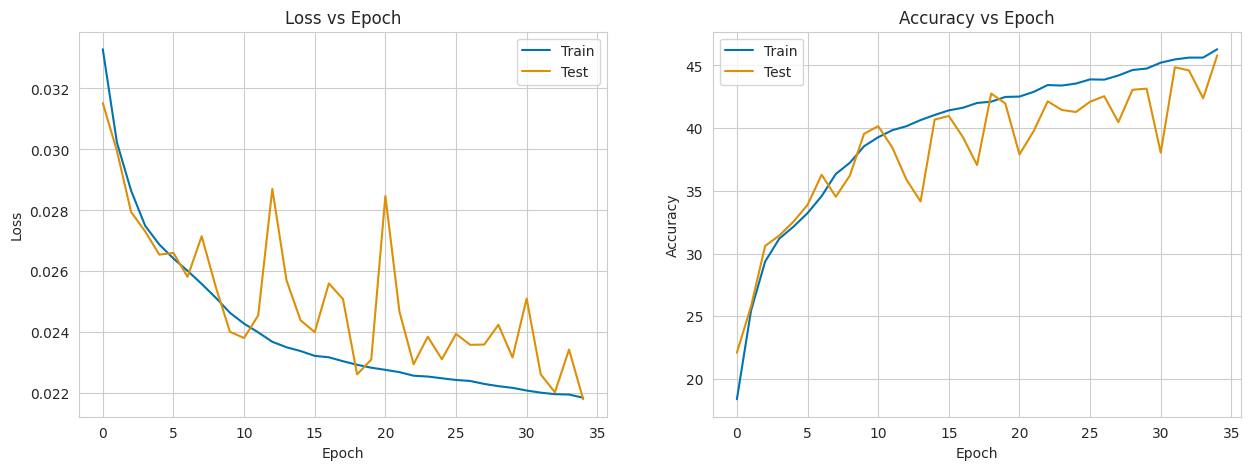

In [71]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.lineplot(ax=axes[0], x=range(NUM_EPOCHS), y=train_loss_per_epoch, label="Train")
sns.lineplot(ax=axes[0], x=range(NUM_EPOCHS), y=test_loss_per_epoch, label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("Loss vs Epoch")

sns.lineplot(ax=axes[1], x=range(NUM_EPOCHS), y=train_accuracy_per_epoch, label="Train")
sns.lineplot(ax=axes[1], x=range(NUM_EPOCHS), y=test_accuracy_per_epoch, label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_title("Accuracy vs Epoch")
plt.savefig("loss_accuracy_plot.png")
plt.show()

# 4. Advance Architecture Model
Since the accuracy of Basic Model is not very impressing and also test accuracy is fluctuating, I have implemented some major chnages in the Architecure and reached the Traininig accuracy of 95% and Test Accuracy of 90%.

* `Changes made`: 
    * Increased Batch size from 64 to 128 to make code compute efficent.
    * Changed Output channels of every block which was fixed in Basic Architecture to 3.
    * Fixed the number of layers in the Output block to 3 in addition with LeakyRelu as activaton and Dropout layers. Which was not the case in Basic Architecture.
    * The intermediate layers of Output block have different output channels, which were fixed to 3 in Basic Architecture.
    * Referred `lab 8` to define conv_arch.


In [27]:

BATCH_SIZE = 128
train_iter, test_iter = load_data_CIFR(BATCH_SIZE, resize=(32, 32))



Files already downloaded and verified
Files already downloaded and verified


## 4.1 Intermediate Blocks for Advance Net model

The `Adv_IntermediateBlock` class defines the Block architecture of my advance model.
* It takes the number of input channels, output channels (required from the second block) and the desired number of convolutional layers.
* Introduced `Adaptive Average Pooling`, `LeakyReLU Activation`, `Max Pooling`, and `Dropout` after each convolutional layer.
* Output channels are `dynamically` set equal to input channels, ensuring compatibility.
* Forward Method:
    * It computes the mean of input tensors using adaptive average pooling, applies a fully connected layer to generate coefficients, and then weights the output of each convolutional layer using these coefficients.

`Adaptive Average Pooling`: Added an AdaptiveAvgPool2d layer to perform adaptive average pooling, ensuring that the output tensor has a fixed size. This helped in handling input tensors of variable sizes.

`Max Pooling and Dropout`: Introduced MaxPool2d and Dropout layers after each convolutional layer. Max pooling downsampled the feature maps and dropout introduced **regularization** to prevent overfitting.


In [32]:
# Define the Intermediate Block
class Adv_IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(Adv_IntermediateBlock, self).__init__()

        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.num_convs = num_convs

        self.convs = []

        for i in range(self.num_convs):
            self.convs.append(nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,stride=1)
                            ,   nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(inplace=True),
                                
                                nn.MaxPool2d(
                                    kernel_size=2, stride=2
                                    ),
                                nn.Dropout(p=0.2)

                              ))

        self.convs = torch.nn.ModuleList(self.convs)

        self.fc = nn.Linear(in_channels, num_convs)

    def forward(self, x):
        m = self.adaptive_avg_pool(x).view(x.size(0), -1)
        a = torch.softmax(self.fc(m), dim=1)  # Calculate 'a' using a fully connected layer

        x_ = self.convs[0](x)

        outPut = []
        for i, conv in enumerate(self.convs):
          outPut.append(a[:, i].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * conv(x))
        x_prime = sum(outPut)
        return x_prime




## 4.2 Output Block for Advance Net Model
The Adv_OutputBlock Class defines the output block architecture of my Advance net model.

* It takes the number of input channels, output channels and the number of output features (that is the number of classes, default set to 10) as parameters. 

* It utilizes `Adaptive Average Pooling` to ensure a fixed-size output tensor regardless of the input size.

* Constructed a sequence of linear layers with leaky ReLU activations and dropout. This allowed for more complex transformations and feature extraction before producing the final output.
  
* Dropout layers to enhance regularization and prevent overfitting during training. To improve the model's generalization ability.

* `Forward Method`:
    * It computes the mean of the input tensor across the width and height dimensions using adaptive average pooling.
    * Then, it passes the resulting tensor through the sequence of linear layers to generate logits as the final output of the model.


In [33]:

class Adv_OutputBlock(nn.Module):
    def __init__(self, in_channels,out_channels,out_features=10):
        super(Adv_OutputBlock, self).__init__()
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(1)
        layers = []
  
        layers.append(nn.Linear(in_channels, out_channels))
        layers.append(nn.LeakyReLU(inplace=True))
        # layers.append(nn.Dropout(p=0.5))

        layers.append(nn.Linear(out_channels, 2*out_channels))
        layers.append(nn.LeakyReLU(inplace=True))
        layers.append(nn.Dropout(p=0.2))

        # layers.append(nn.Linear(2*out_channels, 4*out_channels))
        # layers.append(nn.LeakyReLU(inplace=True))
        
        # layers.append(nn.Linear(4*out_channels, out_channels))
        # layers.append(nn.LeakyReLU(inplace=True))
        layers.append(nn.Dropout(p=0.3))

        layers.append(nn.Linear(2*out_channels, out_features))
        layers.append(nn.LeakyReLU(inplace=True))
        self.fcs = nn.Sequential(*layers)


    def forward(self, x):
        # Calculate channel-wise averages
        # m = x.mean([2, 3])
        m = self.adaptive_avg_pool(x).view(x.size(0), -1)
        # Pass through fully-connected layers
        out = m
        logits = self.fcs(out)
        # Get logits
        # logits = self.fc_last(out)
        return logits




## 4.3 Advance Net Model

The `AdvanceNet` class defines my complete neural network model. 

* It takes several parameters:
  - `conv_arch`: A list specifying the architecture of the convolutional layers in intermediate blocks. Each element of `conv_arch` is a tuple `(out_channels, num_convs)` indicating the number of output channels and the number of convolutional layers for each block.
  - `outBlock_out_channels`: Number of output channels for the output block.
  - `num_classes`: Number of classes. Default is set to 10
  - `in_channels`: Number of input channels. Default is set to 3.

* It creates the specified number of `Intermediate Blocks` using `Adv_IntermediateBlock` instances based on the specified architecture (`conv_arch`). Each block has its own parameters regarding the number of input and output channels, as well as the number of convolutional layers.

* Then final output block is initialized using `Adv_OutputBlock` class. The number of input channels for this block is determined by the last element of the convolutional architecture (`conv_arch[-1][0]`). The number of output channels is specified by `outBock_out_channels`.

* `Forward Method`:
    * It iterates through each intermediate block in the `blocks` ModuleList, applying them sequentially to the input tensor `x`. Then, it passes the resulting tensor through the output block to get the final output, which represents the logits for each class.


In [34]:
# Define the complete network
class AdvanceNet(nn.Module):
    def __init__(self, conv_arch, outBlock_out_channels,num_classes=10, in_channels = 3):
        super(AdvanceNet, self).__init__()
        self.conv_arch = conv_arch

        self.blocks = nn.ModuleList(
            [
                Adv_IntermediateBlock(
                    in_channels if i == 0 else conv_arch[i-1][0],
                    out_channels = params[0],
                    num_convs = params[1],
                )
                for i, params in enumerate(conv_arch)
            ]
        )

        self.out_block = Adv_OutputBlock(conv_arch[-1][0],outBlock_out_channels, num_classes)

    def forward(self, x):
        for i,block in enumerate(self.blocks):
            x = block(x)
        x = self.out_block(x)
        return x


# 5. Training and Testing of Advanced Net Model


## 5.1 Defining hyperparameters, Model, Optimizer and Loss function
* `IN_CHANNELS` --> Number of Input channels = 3, as an image as 3 channels.
* `OUT_BLOCK_OUT_CHANNELS` = 32, Defines the number of output channels for the first linear layer of the output block network.
* `NUM_CLASSES` --> Number of classes = 10.
* `CONV_ARCH` -->  It specifies the architecture of the convolutional layers in the intermediate blocks network. It's a list of tuples, where each tuple contains two values:
    * The first value represents the number of convolutions per block.
    * The second value indicates the number of blocks.
    * For example, (512, 1) means there's one block with 512 convolutions.
    * After experimenting with different combinations such as `[(64, 1), (128, 1), (256, 2), (512, 2), (512, 2)]`, `[(128, 2), (128, 2), (256, 4), (512, 2), (512, 4)]`. But these these architectures did not give an accuracy of more than 86%.
**Loss Function** --> **`CrossEntropy`**
I have used the Cross-Entropy loss function as mentioned. It is commonly used for multiple class classification tasks.

**Optimizer** --> **`ADAM`**
I have used Adam, as it is an adaptive learning rate optimization algorithm that is well-suited for training deep neural networks. It maintains adaptive learning rates for each parameter and computes individual learning rates for different parameters based on estimates of the first and second moments of the gradients. In this case, it's used to optimize the parameters of the model with a learning rate (lr) of 0.001.



In [35]:

# Define network hyperparameters
IN_CHANNELS = 3  # Number of channels in CIFAR-10 images
OUT_BLOCK_OUT_CHANNELS = 32 
NUM_CLASSES = 10  # Number of classes in CIFAR-10
CONV_ARCH = [(512, 1), (512, 1), (512, 2), (512, 2), (512, 4)] # Number of convolutions per block and number of blocks

# Instantiate the model
adv_model = AdvanceNet(CONV_ARCH, OUT_BLOCK_OUT_CHANNELS, NUM_CLASSES, IN_CHANNELS,).to(DEVICE)

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model.parameters(), lr=0.001)



In [36]:
print(adv_model)

AdvanceNet(
  (blocks): ModuleList(
    (0): Adv_IntermediateBlock(
      (adaptive_avg_pool): AdaptiveAvgPool2d(output_size=1)
      (convs): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
      (fc): Linear(in_features=3, out_features=1, bias=True)
    )
    (1): Adv_IntermediateBlock(
      (adaptive_avg_pool): AdaptiveAvgPool2d(output_size=1)
      (convs): ModuleList(
        (0): Sequential(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=

## 5.2 Defining the Training and Testing functions

Same functions as used for Basic Model 

In [37]:
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0

    for data, target in train_loader:
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        data, target = data.to(DEVICE), target.to(DEVICE)  # Move data to device

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100 * correct / len(train_loader.dataset)

    return average_loss, accuracy


def test(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode (no dropout etc.)
    total_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            total_loss += loss.item()

    average_loss = total_loss / len(test_loader.dataset)
    accuracy = 100 * correct / len(test_loader.dataset)

    return average_loss, accuracy

## 5.3 Training the Advance Neural Network Model
NUM_EPOCHS --> Number of Epochs set to 50


In [26]:
from tqdm import tqdm
# torch.manual_seed(100)
NUM_EPOCHS = 50
train_loss_per_epoch = [] #to store train loss of each epoch
train_accuracy_per_epoch = [] #to store train accuracy of each epoch
test_loss_per_epoch = [] #to store test loss of each epoch
test_accuracy_per_epoch = [] #to store test accuracy of each epoch
# Training loop
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    train_loss, train_accuracy = train(adv_model, train_iter, criterion, optimizer)
    test_loss, test_accuracy = test(adv_model, test_iter, criterion)
    
    train_loss_per_epoch.append(train_loss)
    train_accuracy_per_epoch.append(train_accuracy)
    test_loss_per_epoch.append(test_loss)
    test_accuracy_per_epoch.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print("--------------------------------------------")


Epochs:   2%|▏         | 1/50 [00:58<47:35, 58.28s/it]

Epoch [1/50], Train Loss: 0.0132, Train Accuracy: 38.03%
Epoch [1/50], Test Loss: 0.0097, Test Accuracy: 55.69%
--------------------------------------------


Epochs:   4%|▍         | 2/50 [01:54<45:44, 57.17s/it]

Epoch [2/50], Train Loss: 0.0096, Train Accuracy: 57.10%
Epoch [2/50], Test Loss: 0.0077, Test Accuracy: 65.06%
--------------------------------------------


Epochs:   6%|▌         | 3/50 [02:52<45:04, 57.54s/it]

Epoch [3/50], Train Loss: 0.0081, Train Accuracy: 63.99%
Epoch [3/50], Test Loss: 0.0071, Test Accuracy: 68.81%
--------------------------------------------


Epochs:   8%|▊         | 4/50 [03:49<43:51, 57.21s/it]

Epoch [4/50], Train Loss: 0.0072, Train Accuracy: 68.39%
Epoch [4/50], Test Loss: 0.0061, Test Accuracy: 72.83%
--------------------------------------------


Epochs:  10%|█         | 5/50 [04:45<42:30, 56.69s/it]

Epoch [5/50], Train Loss: 0.0066, Train Accuracy: 71.38%
Epoch [5/50], Test Loss: 0.0058, Test Accuracy: 73.79%
--------------------------------------------


Epochs:  12%|█▏        | 6/50 [05:43<42:05, 57.41s/it]

Epoch [6/50], Train Loss: 0.0060, Train Accuracy: 73.93%
Epoch [6/50], Test Loss: 0.0055, Test Accuracy: 76.34%
--------------------------------------------


Epochs:  14%|█▍        | 7/50 [06:42<41:28, 57.87s/it]

Epoch [7/50], Train Loss: 0.0056, Train Accuracy: 75.54%
Epoch [7/50], Test Loss: 0.0052, Test Accuracy: 77.51%
--------------------------------------------


Epochs:  16%|█▌        | 8/50 [07:43<41:09, 58.79s/it]

Epoch [8/50], Train Loss: 0.0053, Train Accuracy: 77.22%
Epoch [8/50], Test Loss: 0.0048, Test Accuracy: 79.11%
--------------------------------------------


Epochs:  18%|█▊        | 9/50 [08:43<40:25, 59.17s/it]

Epoch [9/50], Train Loss: 0.0049, Train Accuracy: 78.98%
Epoch [9/50], Test Loss: 0.0046, Test Accuracy: 80.05%
--------------------------------------------


Epochs:  20%|██        | 10/50 [09:43<39:33, 59.35s/it]

Epoch [10/50], Train Loss: 0.0047, Train Accuracy: 79.86%
Epoch [10/50], Test Loss: 0.0048, Test Accuracy: 79.88%
--------------------------------------------


Epochs:  22%|██▏       | 11/50 [10:43<38:39, 59.48s/it]

Epoch [11/50], Train Loss: 0.0045, Train Accuracy: 80.62%
Epoch [11/50], Test Loss: 0.0044, Test Accuracy: 81.29%
--------------------------------------------


Epochs:  24%|██▍       | 12/50 [11:48<38:49, 61.31s/it]

Epoch [12/50], Train Loss: 0.0042, Train Accuracy: 82.12%
Epoch [12/50], Test Loss: 0.0043, Test Accuracy: 81.56%
--------------------------------------------


Epochs:  26%|██▌       | 13/50 [12:56<39:01, 63.27s/it]

Epoch [13/50], Train Loss: 0.0041, Train Accuracy: 82.71%
Epoch [13/50], Test Loss: 0.0037, Test Accuracy: 84.54%
--------------------------------------------


Epochs:  28%|██▊       | 14/50 [14:02<38:31, 64.22s/it]

Epoch [14/50], Train Loss: 0.0038, Train Accuracy: 83.90%
Epoch [14/50], Test Loss: 0.0037, Test Accuracy: 84.30%
--------------------------------------------


Epochs:  30%|███       | 15/50 [15:11<38:12, 65.50s/it]

Epoch [15/50], Train Loss: 0.0037, Train Accuracy: 84.56%
Epoch [15/50], Test Loss: 0.0037, Test Accuracy: 84.86%
--------------------------------------------


Epochs:  32%|███▏      | 16/50 [16:16<37:05, 65.46s/it]

Epoch [16/50], Train Loss: 0.0036, Train Accuracy: 85.08%
Epoch [16/50], Test Loss: 0.0035, Test Accuracy: 85.34%
--------------------------------------------


Epochs:  34%|███▍      | 17/50 [17:24<36:24, 66.20s/it]

Epoch [17/50], Train Loss: 0.0034, Train Accuracy: 85.75%
Epoch [17/50], Test Loss: 0.0036, Test Accuracy: 84.87%
--------------------------------------------


Epochs:  36%|███▌      | 18/50 [18:31<35:28, 66.50s/it]

Epoch [18/50], Train Loss: 0.0032, Train Accuracy: 86.41%
Epoch [18/50], Test Loss: 0.0034, Test Accuracy: 85.76%
--------------------------------------------


Epochs:  38%|███▊      | 19/50 [19:38<34:24, 66.59s/it]

Epoch [19/50], Train Loss: 0.0031, Train Accuracy: 86.93%
Epoch [19/50], Test Loss: 0.0032, Test Accuracy: 86.69%
--------------------------------------------


Epochs:  40%|████      | 20/50 [20:42<32:55, 65.86s/it]

Epoch [20/50], Train Loss: 0.0030, Train Accuracy: 87.52%
Epoch [20/50], Test Loss: 0.0035, Test Accuracy: 86.05%
--------------------------------------------


Epochs:  42%|████▏     | 21/50 [21:49<32:01, 66.26s/it]

Epoch [21/50], Train Loss: 0.0029, Train Accuracy: 87.96%
Epoch [21/50], Test Loss: 0.0031, Test Accuracy: 87.16%
--------------------------------------------


Epochs:  44%|████▍     | 22/50 [22:55<30:53, 66.20s/it]

Epoch [22/50], Train Loss: 0.0027, Train Accuracy: 88.54%
Epoch [22/50], Test Loss: 0.0032, Test Accuracy: 86.75%
--------------------------------------------


Epochs:  46%|████▌     | 23/50 [24:04<30:05, 66.88s/it]

Epoch [23/50], Train Loss: 0.0026, Train Accuracy: 88.78%
Epoch [23/50], Test Loss: 0.0032, Test Accuracy: 87.32%
--------------------------------------------


Epochs:  48%|████▊     | 24/50 [25:11<29:01, 66.99s/it]

Epoch [24/50], Train Loss: 0.0025, Train Accuracy: 89.27%
Epoch [24/50], Test Loss: 0.0032, Test Accuracy: 87.19%
--------------------------------------------


Epochs:  50%|█████     | 25/50 [26:19<27:59, 67.20s/it]

Epoch [25/50], Train Loss: 0.0024, Train Accuracy: 89.85%
Epoch [25/50], Test Loss: 0.0030, Test Accuracy: 88.02%
--------------------------------------------


Epochs:  52%|█████▏    | 26/50 [27:26<26:52, 67.20s/it]

Epoch [26/50], Train Loss: 0.0024, Train Accuracy: 90.05%
Epoch [26/50], Test Loss: 0.0032, Test Accuracy: 87.43%
--------------------------------------------


Epochs:  54%|█████▍    | 27/50 [28:35<25:55, 67.62s/it]

Epoch [27/50], Train Loss: 0.0023, Train Accuracy: 90.46%
Epoch [27/50], Test Loss: 0.0032, Test Accuracy: 87.76%
--------------------------------------------


Epochs:  56%|█████▌    | 28/50 [29:42<24:47, 67.62s/it]

Epoch [28/50], Train Loss: 0.0022, Train Accuracy: 90.72%
Epoch [28/50], Test Loss: 0.0029, Test Accuracy: 88.01%
--------------------------------------------


Epochs:  58%|█████▊    | 29/50 [30:46<23:14, 66.41s/it]

Epoch [29/50], Train Loss: 0.0021, Train Accuracy: 91.09%
Epoch [29/50], Test Loss: 0.0031, Test Accuracy: 88.39%
--------------------------------------------


Epochs:  60%|██████    | 30/50 [31:52<22:06, 66.33s/it]

Epoch [30/50], Train Loss: 0.0020, Train Accuracy: 91.37%
Epoch [30/50], Test Loss: 0.0028, Test Accuracy: 89.17%
--------------------------------------------


Epochs:  62%|██████▏   | 31/50 [32:56<20:45, 65.53s/it]

Epoch [31/50], Train Loss: 0.0020, Train Accuracy: 91.52%
Epoch [31/50], Test Loss: 0.0031, Test Accuracy: 88.52%
--------------------------------------------


Epochs:  64%|██████▍   | 32/50 [34:01<19:38, 65.49s/it]

Epoch [32/50], Train Loss: 0.0019, Train Accuracy: 91.77%
Epoch [32/50], Test Loss: 0.0031, Test Accuracy: 88.68%
--------------------------------------------


Epochs:  66%|██████▌   | 33/50 [35:00<18:02, 63.69s/it]

Epoch [33/50], Train Loss: 0.0019, Train Accuracy: 92.05%
Epoch [33/50], Test Loss: 0.0030, Test Accuracy: 89.08%
--------------------------------------------


Epochs:  68%|██████▊   | 34/50 [35:53<16:04, 60.29s/it]

Epoch [34/50], Train Loss: 0.0018, Train Accuracy: 92.52%
Epoch [34/50], Test Loss: 0.0029, Test Accuracy: 89.27%
--------------------------------------------


Epochs:  70%|███████   | 35/50 [36:42<14:13, 56.88s/it]

Epoch [35/50], Train Loss: 0.0018, Train Accuracy: 92.49%
Epoch [35/50], Test Loss: 0.0030, Test Accuracy: 88.93%
--------------------------------------------


Epochs:  72%|███████▏  | 36/50 [37:41<13:26, 57.63s/it]

Epoch [36/50], Train Loss: 0.0017, Train Accuracy: 92.82%
Epoch [36/50], Test Loss: 0.0032, Test Accuracy: 88.36%
--------------------------------------------


Epochs:  74%|███████▍  | 37/50 [38:41<12:35, 58.15s/it]

Epoch [37/50], Train Loss: 0.0017, Train Accuracy: 93.02%
Epoch [37/50], Test Loss: 0.0030, Test Accuracy: 89.42%
--------------------------------------------


Epochs:  76%|███████▌  | 38/50 [39:41<11:46, 58.85s/it]

Epoch [38/50], Train Loss: 0.0016, Train Accuracy: 93.14%
Epoch [38/50], Test Loss: 0.0030, Test Accuracy: 89.16%
--------------------------------------------


Epochs:  78%|███████▊  | 39/50 [40:40<10:46, 58.80s/it]

Epoch [39/50], Train Loss: 0.0015, Train Accuracy: 93.48%
Epoch [39/50], Test Loss: 0.0033, Test Accuracy: 88.97%
--------------------------------------------


Epochs:  80%|████████  | 40/50 [41:38<09:47, 58.77s/it]

Epoch [40/50], Train Loss: 0.0015, Train Accuracy: 93.50%
Epoch [40/50], Test Loss: 0.0030, Test Accuracy: 89.34%
--------------------------------------------


Epochs:  82%|████████▏ | 41/50 [42:33<08:38, 57.59s/it]

Epoch [41/50], Train Loss: 0.0014, Train Accuracy: 93.89%
Epoch [41/50], Test Loss: 0.0030, Test Accuracy: 89.54%
--------------------------------------------


Epochs:  84%|████████▍ | 42/50 [43:23<07:22, 55.37s/it]

Epoch [42/50], Train Loss: 0.0015, Train Accuracy: 93.56%
Epoch [42/50], Test Loss: 0.0030, Test Accuracy: 89.33%
--------------------------------------------


Epochs:  86%|████████▌ | 43/50 [44:13<06:15, 53.65s/it]

Epoch [43/50], Train Loss: 0.0014, Train Accuracy: 94.02%
Epoch [43/50], Test Loss: 0.0030, Test Accuracy: 90.06%
--------------------------------------------


Epochs:  88%|████████▊ | 44/50 [44:56<05:03, 50.59s/it]

Epoch [44/50], Train Loss: 0.0014, Train Accuracy: 94.20%
Epoch [44/50], Test Loss: 0.0030, Test Accuracy: 89.83%
--------------------------------------------


Epochs:  90%|█████████ | 45/50 [45:40<04:02, 48.58s/it]

Epoch [45/50], Train Loss: 0.0013, Train Accuracy: 94.27%
Epoch [45/50], Test Loss: 0.0030, Test Accuracy: 89.26%
--------------------------------------------


Epochs:  92%|█████████▏| 46/50 [46:22<03:06, 46.55s/it]

Epoch [46/50], Train Loss: 0.0013, Train Accuracy: 94.53%
Epoch [46/50], Test Loss: 0.0031, Test Accuracy: 89.37%
--------------------------------------------


Epochs:  94%|█████████▍| 47/50 [47:05<02:16, 45.49s/it]

Epoch [47/50], Train Loss: 0.0013, Train Accuracy: 94.64%
Epoch [47/50], Test Loss: 0.0032, Test Accuracy: 89.69%
--------------------------------------------


Epochs:  96%|█████████▌| 48/50 [47:49<01:30, 45.11s/it]

Epoch [48/50], Train Loss: 0.0012, Train Accuracy: 94.72%
Epoch [48/50], Test Loss: 0.0034, Test Accuracy: 89.49%
--------------------------------------------


Epochs:  98%|█████████▊| 49/50 [48:29<00:43, 43.42s/it]

Epoch [49/50], Train Loss: 0.0012, Train Accuracy: 94.92%
Epoch [49/50], Test Loss: 0.0033, Test Accuracy: 89.49%
--------------------------------------------


Epochs: 100%|██████████| 50/50 [49:08<00:00, 58.97s/it]

Epoch [50/50], Train Loss: 0.0012, Train Accuracy: 95.02%
Epoch [50/50], Test Loss: 0.0032, Test Accuracy: 89.48%
--------------------------------------------


### Maximum test accuracy achieved at Epoch 43 where,
`Train Loss`: 0.0014, `Train Accuracy`: 94.02%
`Test Loss`: 0.0030, `Test Accuracy`: 90.06%

### Final Accuracies and Losses after 50th Epoch
`Train Loss`: 0.0012, `Train Accuracy`: 95.02%
`Test Loss`: 0.0032, `Test Accuracy`: 89.48%

## 5.4 Plotting Train and Test Loss & Train and test accuracy for each Epoch

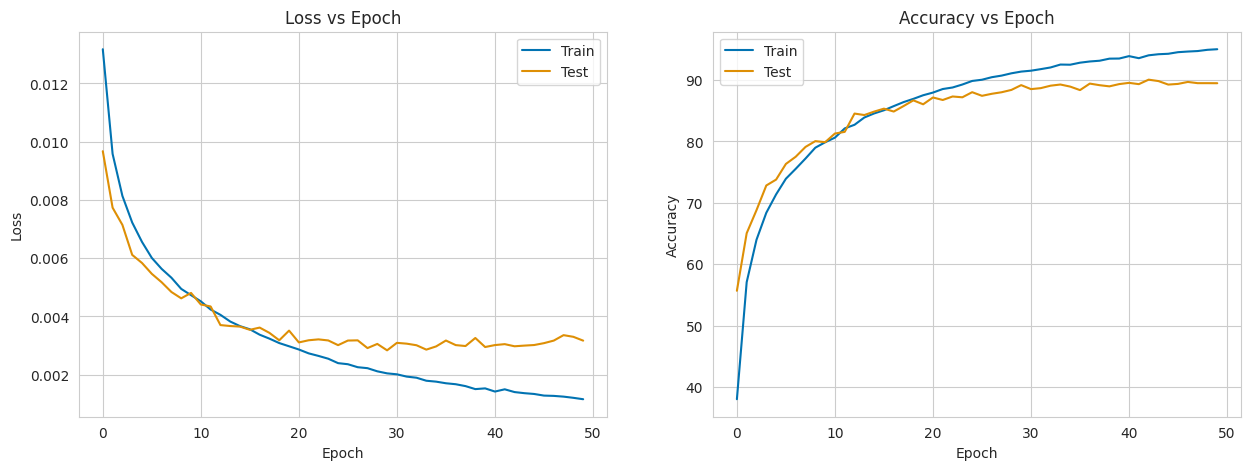

In [28]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.lineplot(ax=axes[0], x=range(NUM_EPOCHS), y=train_loss_per_epoch, label="Train")
sns.lineplot(ax=axes[0], x=range(NUM_EPOCHS), y=test_loss_per_epoch, label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("Loss vs Epoch")

sns.lineplot(ax=axes[1], x=range(NUM_EPOCHS), y=train_accuracy_per_epoch, label="Train")
sns.lineplot(ax=axes[1], x=range(NUM_EPOCHS), y=test_accuracy_per_epoch, label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_title("Accuracy vs Epoch")
plt.savefig("loss_accuracy_plot.png")
plt.show()